## Give Me Some Credit

This is a case study, with data from the Kaggle competition "Give Me Some Credit".
According to the website description:
Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

The goal of this competition is to build a model that borrowers can use to help make the best financial decisions.

Credit Fusion, Will Cukierski. (2011). Give Me Some Credit. Kaggle. https://kaggle.com/competitions/GiveMeSomeCredit

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from fancyimpute import IterativeImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, roc_curve, fbeta_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
from sklearn.inspection import permutation_importance

## Functions

In [54]:
# add plot statistics
def add_stats_to_plot(data, x, ax):
    mean_val = data[x].mean()
    std_val = data[x].std()
    median_val = data[x].median()
    mode_val = data[x].mode().iloc[0]
    min_val = data[x].min()
    max_val = data[x].max()

    stats_text = (
        f"Mean: {mean_val:.2f}\n"
        f"Std: {std_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"Mode: {mode_val:.2f}\n"
        f"Min: {min_val:.2f}\n"
        f"Max: {max_val:.2f}"
    )

    bbox_props = dict(boxstyle='round,pad=0.3', fc='white', ec='gray', lw=0.5)

    ax.text(0.5, 0.8, stats_text, transform=ax.transAxes, fontsize=9, ha='center', va='center',
            bbox=bbox_props, color='black')


# Plot the ROC curve
def plot_roc_curve_custom(model, X, y, title, ax):
    y_pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    auc_score = roc_auc_score(y, y_pred_proba)
    ax.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')


#Function to evaluate models with default hiperparameters
def train_and_evaluate_models(X_train, X_test, y_train, y_test, X_train_resampled, y_train_resampled):
    # List to save results
    results = []
    
    # Algorithms
    models = {
        "Random Forest": RandomForestClassifier(),
        "LOG Reg": LogisticRegression(max_iter=1000, penalty='l2'),
        "XGBoost": XGBClassifier(),
        "LGBoost": LGBMClassifier()
    }
    
    # Umbalanced Data
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        recall_train = recall_score(y_train, y_pred_train, average='weighted')
        precision_train = precision_score(y_train, y_pred_train, average='weighted')
        auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1], average='weighted')
        f1_train = f1_score(y_train, y_pred_train, average='weighted')
        recall_test = recall_score(y_test, y_pred_test, average='weighted')
        precision_test = precision_score(y_test, y_pred_test, average='weighted')
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], average='weighted')
        f1_test = f1_score(y_test, y_pred_test, average='weighted')
        
        results.append({
            "Model": model_name,
            "Data": "Unbalanced",
            "Recall": recall_train,
            "Precision": precision_train,
            "AUC": auc_train,
            "F1-Score": f1_train
        })
        results.append({
            "Model": model_name,
            "Data": "Unbalanced - Test",
            "Recall": recall_test,
            "Precision": precision_test,
            "AUC": auc_test,
            "F1-Score": f1_test
        })
    # SMOTE data
    for model_name, model in models.items():
        model.fit(X_train_resampled, y_train_resampled)
        y_pred_train = model.predict(X_train_resampled)
        y_pred_test = model.predict(X_test)
        recall_train = recall_score(y_train_resampled, y_pred_train, average='macro')
        precision_train = precision_score(y_train_resampled, y_pred_train, average='macro')
        auc_train = roc_auc_score(y_train_resampled, model.predict_proba(X_train_resampled)[:, 1], average='macro')
        f1_train = f1_score(y_train_resampled, y_pred_train, average='macro')
        recall_test = recall_score(y_test, y_pred_test, average='macro')
        precision_test = precision_score(y_test, y_pred_test, average='macro')
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], average='macro')
        f1_test = f1_score(y_test, y_pred_test, average='macro')
        
        results.append({
            "Model": model_name,
            "Data": "SMOTE",
            "Recall": recall_train,
            "Precision": precision_train,
            "AUC": auc_train,
            "F1-Score": f1_train
        })
        results.append({
            "Model": model_name,
            "Data": "SMOTE - Test",
            "Recall": recall_test,
            "Precision": precision_test,
            "AUC": auc_test,
            "F1-Score": f1_test
        })

    # Print Results
    for result in results:
        print(result)

    return results

## Exploratory Data Analysis

In [2]:
# Import data
raw_data = pd.read_csv('training_data.csv', 
                        header=0, 
                        index_col=0)

# Data structure
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

In [3]:
round(raw_data.describe(), 3)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000,150000.000,150000.000,150000.000,150000.000,120269.000,150000.000,150000.000,150000.000,150000.000,146076.000
mean,0.067,6.048,52.295,0.421,353.005,6670.221,8.453,0.266,1.018,0.240,0.757
std,0.250,249.755,14.772,4.193,2037.819,14384.674,5.146,4.169,1.130,4.155,1.115
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.030,41.000,0.000,0.175,3400.000,5.000,0.000,0.000,0.000,0.000
50%,0.000,0.154,52.000,0.000,0.367,5400.000,8.000,0.000,1.000,0.000,0.000
75%,0.000,0.559,63.000,0.000,0.868,8249.000,11.000,0.000,2.000,0.000,1.000
max,1.000,50708.000,109.000,98.000,329664.000,3008750.000,58.000,98.000,54.000,98.000,20.000


Some variables like MonthlyIncome, RevolvingUtilizationOfUnsecuredLines, DebtRatio, have high standard deviation from the mean.
The large difference between mean and median (50%) also indicates high variability in data distribution.

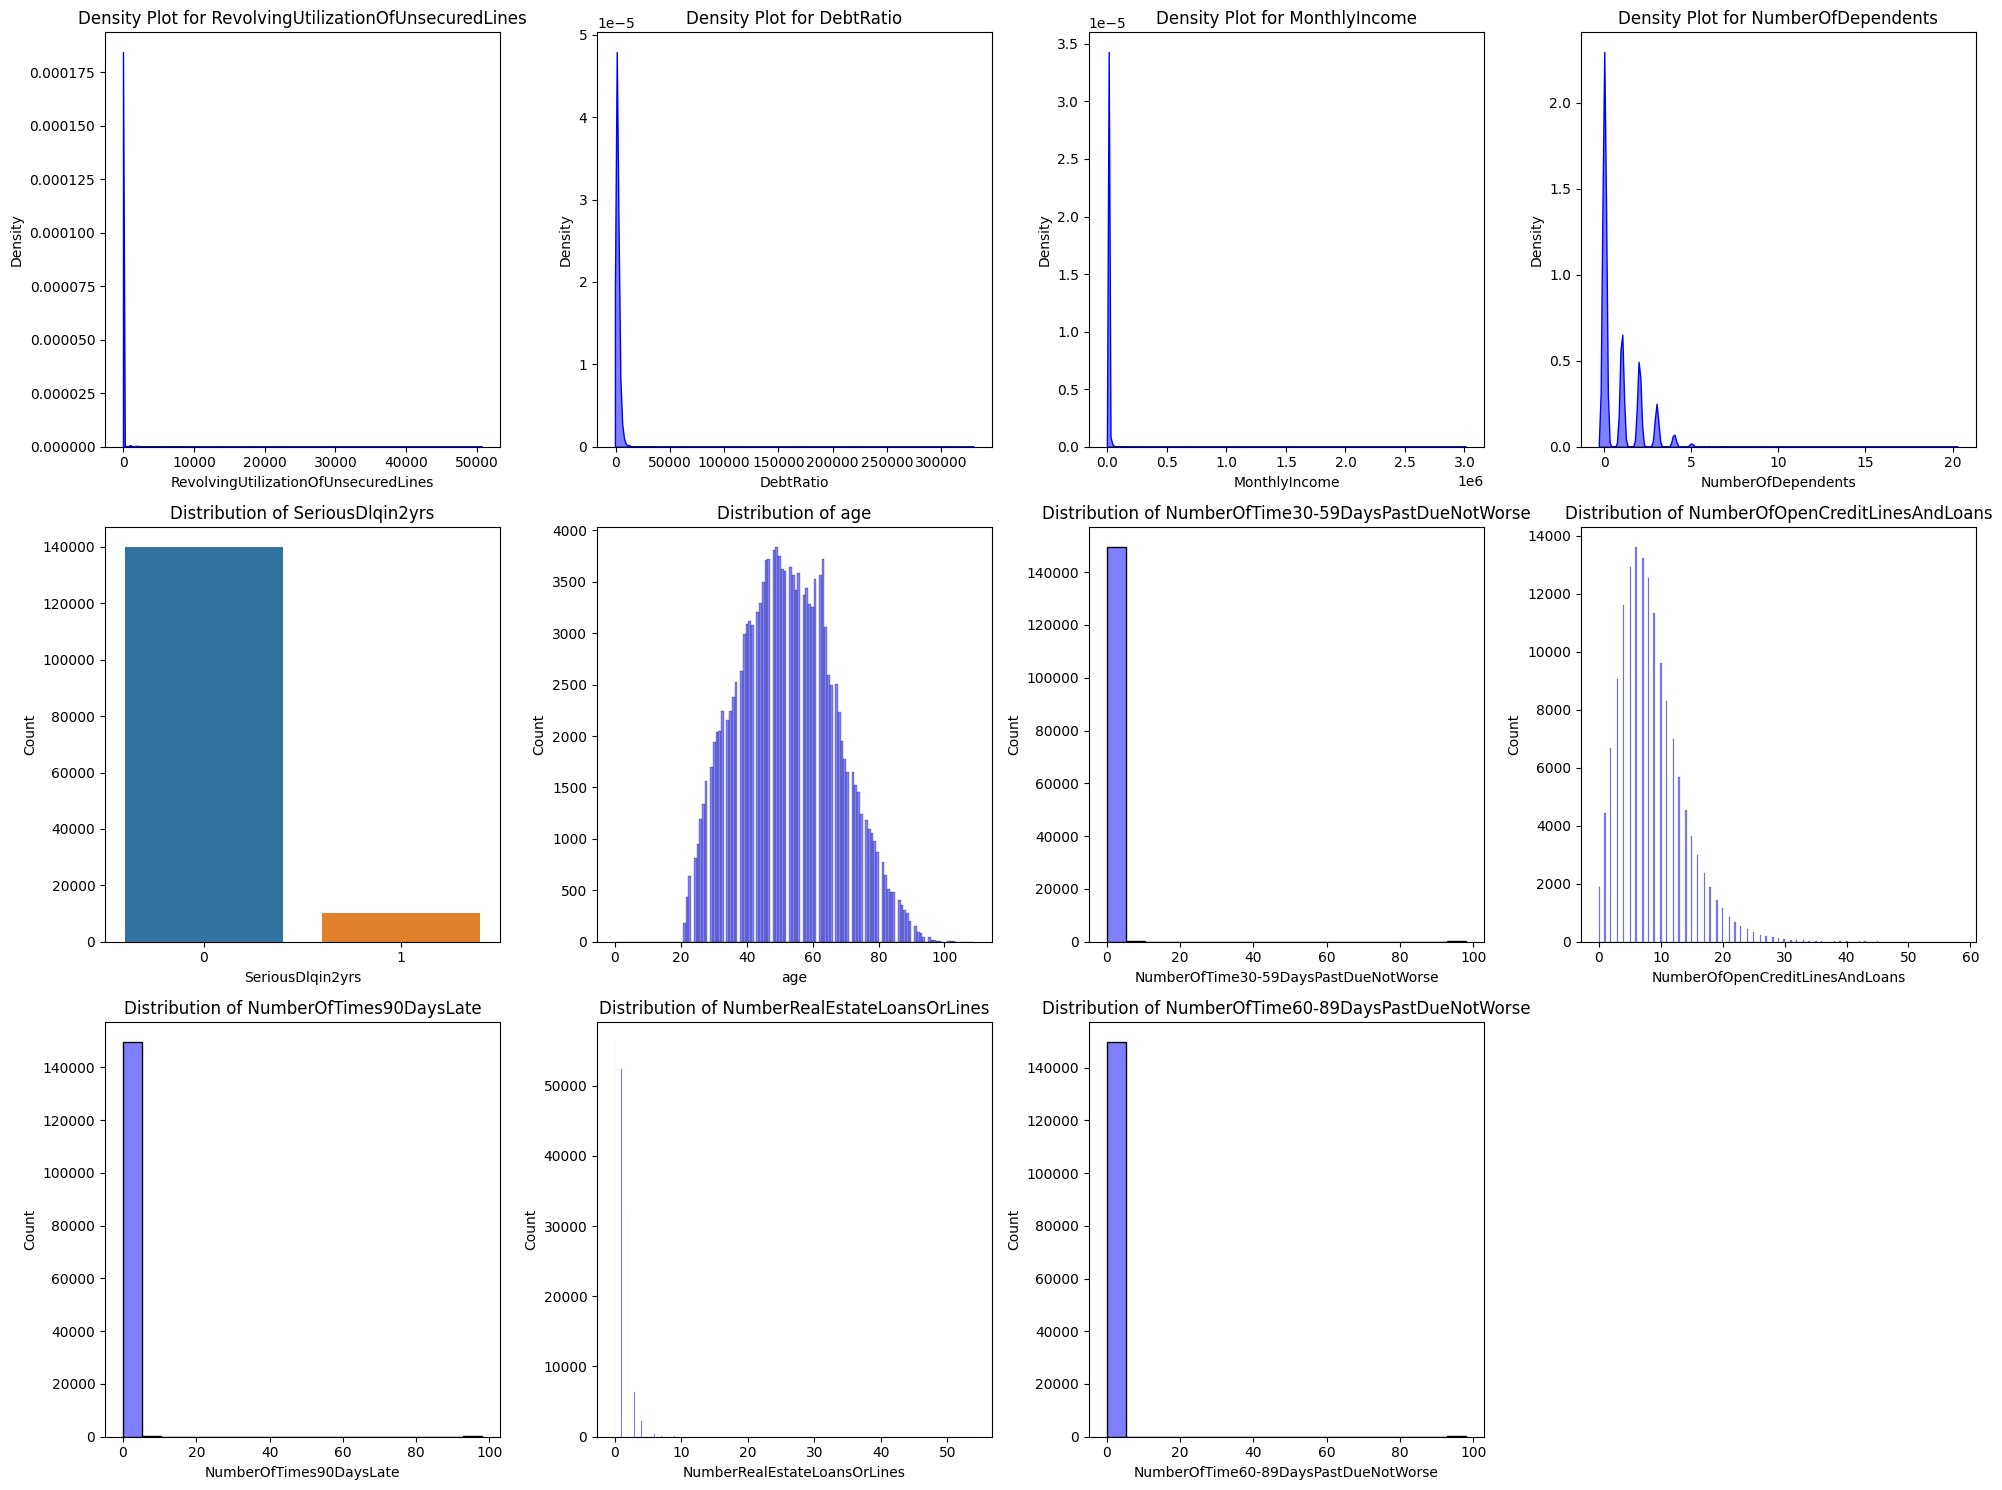

In [10]:
# Split continuos and discrete variables
numerical_continuous = raw_data.select_dtypes(include=['float'])
numerical_discrete = raw_data.select_dtypes(include=['int'])

# config grid
plt.figure(figsize=(20, 15))
gs = plt.GridSpec(3, 4)

# Plot density
for i, column in enumerate(numerical_continuous.columns[:4]):
    ax = plt.subplot(gs[0, i])
    sns.kdeplot(data=numerical_continuous[column], fill=True, color='blue', alpha=0.5, ax=ax)
    ax.set_title(f"Density Plot for {column}")
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

# Plot histogram
for i, column in enumerate(numerical_discrete.columns[:4]):
    ax = plt.subplot(gs[1, i])
    if len(numerical_discrete[column].unique()) <= 10:
        # Bar plot if less then 10 levels
        sns.countplot(data=numerical_discrete, x=column, ax=ax)
    else:
        # Hist if more then 10
        sns.histplot(data=numerical_discrete[column], kde=False, color='blue', alpha=0.5, ax=ax)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Plot histogram or barplot
for i, column in enumerate(numerical_discrete.columns[4:]):
    ax = plt.subplot(gs[2, i])
    if len(numerical_discrete[column].unique()) <= 10:
        # Bar plot if less then 10 levels
        sns.countplot(data=numerical_discrete, x=column, ax=ax)
    else:
        # Hist if more then 10
        sns.histplot(data=numerical_discrete[column], kde=False, color='blue', alpha=0.5, ax=ax)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Remove empty space
plt.subplot(gs[2, 3]).set_visible(False)

plt.tight_layout()
plt.show()

In [3]:
# Select variables target and age (good distribution)
predictors = raw_data.drop(columns=['SeriousDlqin2yrs', 'age'])

# Calculate z-score
z_scores = np.abs((predictors - predictors.mean()) / predictors.std())

# Z-score thershold
z_score_limit = 4.0

# Count number of observations more than 4.0
observations_to_remove = (z_scores > z_score_limit).sum()
print("Number of observations to me removed:")
print(observations_to_remove)

Number of observations to me removed:
RevolvingUtilizationOfUnsecuredLines    172
NumberOfTime30-59DaysPastDueNotWorse    269
DebtRatio                               282
MonthlyIncome                           193
NumberOfOpenCreditLinesAndLoans         442
NumberOfTimes90DaysLate                 270
NumberRealEstateLoansOrLines            793
NumberOfTime60-89DaysPastDueNotWorse    269
NumberOfDependents                      245
dtype: int64


In [4]:
# Create boolean mask
mask_to_remove = (z_scores > z_score_limit).any(axis=1)
# New df
removed_outliers = raw_data[~mask_to_remove]

To deal with the skewed distributions, the outlier removal was performed using the Z score (assuming that the distributions tend to normality). The threshold value of 4 was used, because with stricter values ​​there was a greater amount of data removal.

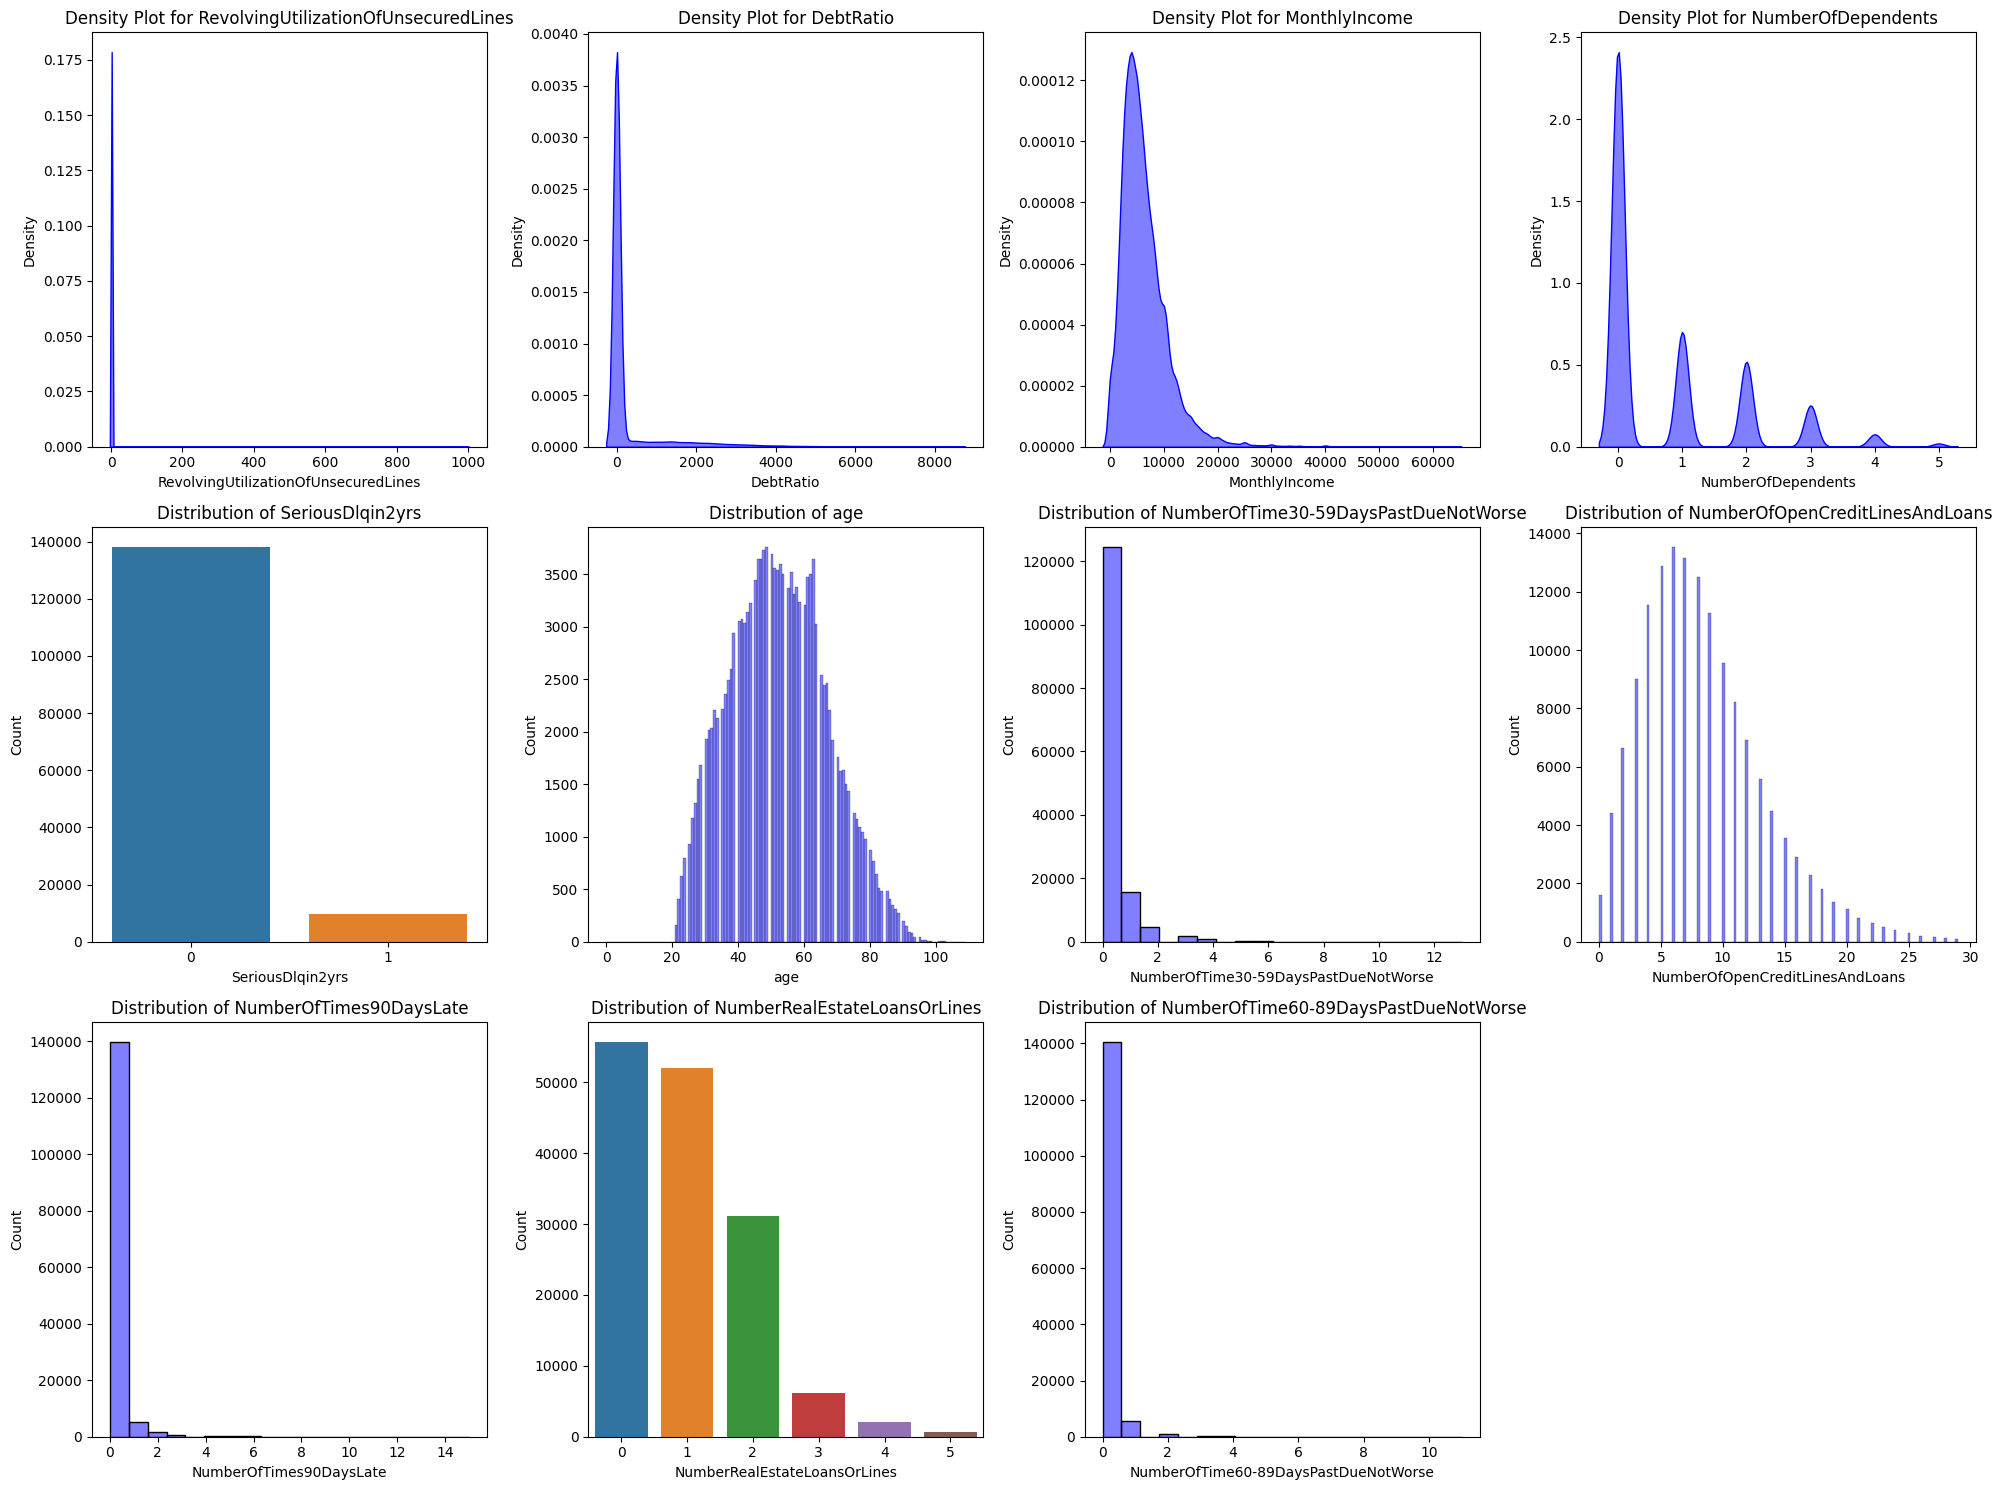

In [28]:
# Same plot as before
numerical_continuous = removed_outliers.select_dtypes(include=['float'])
numerical_discrete = removed_outliers.select_dtypes(include=['int'])

plt.figure(figsize=(20, 15))
gs = plt.GridSpec(3, 4)

for i, column in enumerate(numerical_continuous.columns[:4]):
    ax = plt.subplot(gs[0, i])
    sns.kdeplot(data=numerical_continuous[column], fill=True, color='blue', alpha=0.5, ax=ax)
    ax.set_title(f"Density Plot for {column}")
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

for i, column in enumerate(numerical_discrete.columns[:4]):
    ax = plt.subplot(gs[1, i])
    if len(numerical_discrete[column].unique()) <= 10:
        sns.countplot(data=numerical_discrete, x=column, ax=ax)
    else:
        sns.histplot(data=numerical_discrete[column], kde=False, color='blue', alpha=0.5, ax=ax)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

for i, column in enumerate(numerical_discrete.columns[4:]):
    ax = plt.subplot(gs[2, i])
    if len(numerical_discrete[column].unique()) <= 10:
        sns.countplot(data=numerical_discrete, x=column, ax=ax)
    else:
        sns.histplot(data=numerical_discrete[column], kde=False, color='blue', alpha=0.5, ax=ax)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

plt.subplot(gs[2, 3]).set_visible(False)
plt.tight_layout()
plt.show()

[[0, 0.06524064171122995], [1, 0.38752783964365256], [2, 0.21717171717171718], [3, 0.15126050420168066], [4, 0.13043478260869565], [5, 0.12195121951219512], [6, 0.12], [7, 0.125], [8, 0.11267605633802817], [9, 0.10144927536231885], [10, 0.10144927536231885], [11, 0.10144927536231885], [12, 0.08823529411764706], [13, 0.06060606060606061], [14, 0.06060606060606061], [15, 0.047619047619047616], [16, 0.047619047619047616], [17, 0.047619047619047616], [18, 0.047619047619047616], [19, 0.04838709677419355]]


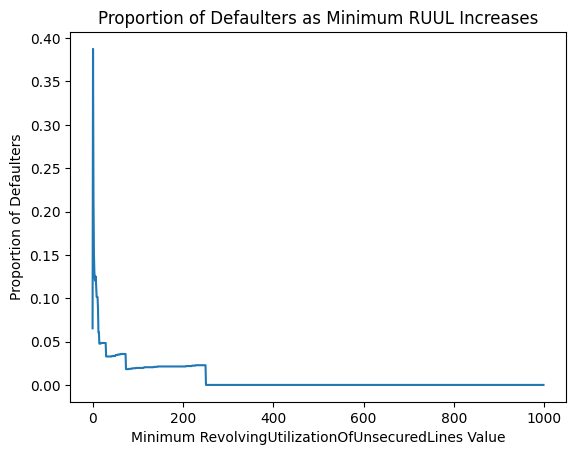

In [5]:
default_prop_revolving = []
for i in range(int(removed_outliers["RevolvingUtilizationOfUnsecuredLines"].max())):
    temp_ = removed_outliers.loc[removed_outliers["RevolvingUtilizationOfUnsecuredLines"] >= i]
    default_prop_revolving.append([i, temp_["SeriousDlqin2yrs"].mean()])

print(default_prop_revolving[:20])
# Plot the line graph
sns.lineplot(x=[i[0] for i in default_prop_revolving], y=[i[1] for i in default_prop_revolving])

# Add the legends
plt.title("Proportion of Defaulters as Minimum RUUL Increases")
plt.xlabel("Minimum RevolvingUtilizationOfUnsecuredLines Value")
plt.ylabel("Proportion of Defaulters")
plt.show()

The variable "RevolvingUtilizationOfUnsecuredLines" represents the proportion of available credit that the customer is using. In other words, it indicates the amount of credit the customer uses in relation to the total credit available to him.
When this proportion increases, the customer uses more of the available credit, which may indicate greater indebtedness. In this context, it is expected that, as the customer becomes more indebted, their ability to pay debts may also be compromised, leading to a greater risk of default.
Therefore, when observing the distribution of "RevolvingUtilizationOfUnsecuredLines" in relation to the proportion of "SeriousDlqin2yrs", it is noted that when reaching the value of 13 for "RevolvingUtilizationOfUnsecuredLines", the proportion of "SeriousDlqin2yrs" decreases, indicating that the removal of observations above of this value must be removed from the dataset.

In [6]:
removed_outliers_RUUL = removed_outliers[removed_outliers['RevolvingUtilizationOfUnsecuredLines'] < 13]

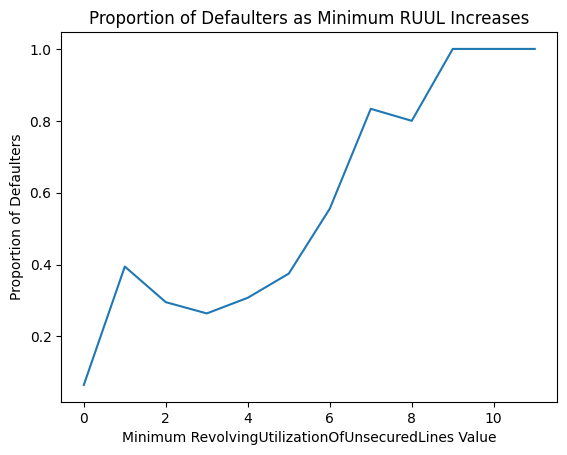

In [8]:
default_prop_revolving = []
for i in range(int(removed_outliers_RUUL["RevolvingUtilizationOfUnsecuredLines"].max())):
    temp_ = removed_outliers_RUUL.loc[removed_outliers_RUUL["RevolvingUtilizationOfUnsecuredLines"] >= i]
    default_prop_revolving.append([i, temp_["SeriousDlqin2yrs"].mean()])
# Plot the line graph
sns.lineplot(x=[i[0] for i in default_prop_revolving], y=[i[1] for i in default_prop_revolving])

# Add the legends
plt.title("Proportion of Defaulters as Minimum RUUL Increases")
plt.xlabel("Minimum RevolvingUtilizationOfUnsecuredLines Value")
plt.ylabel("Proportion of Defaulters")
plt.show()

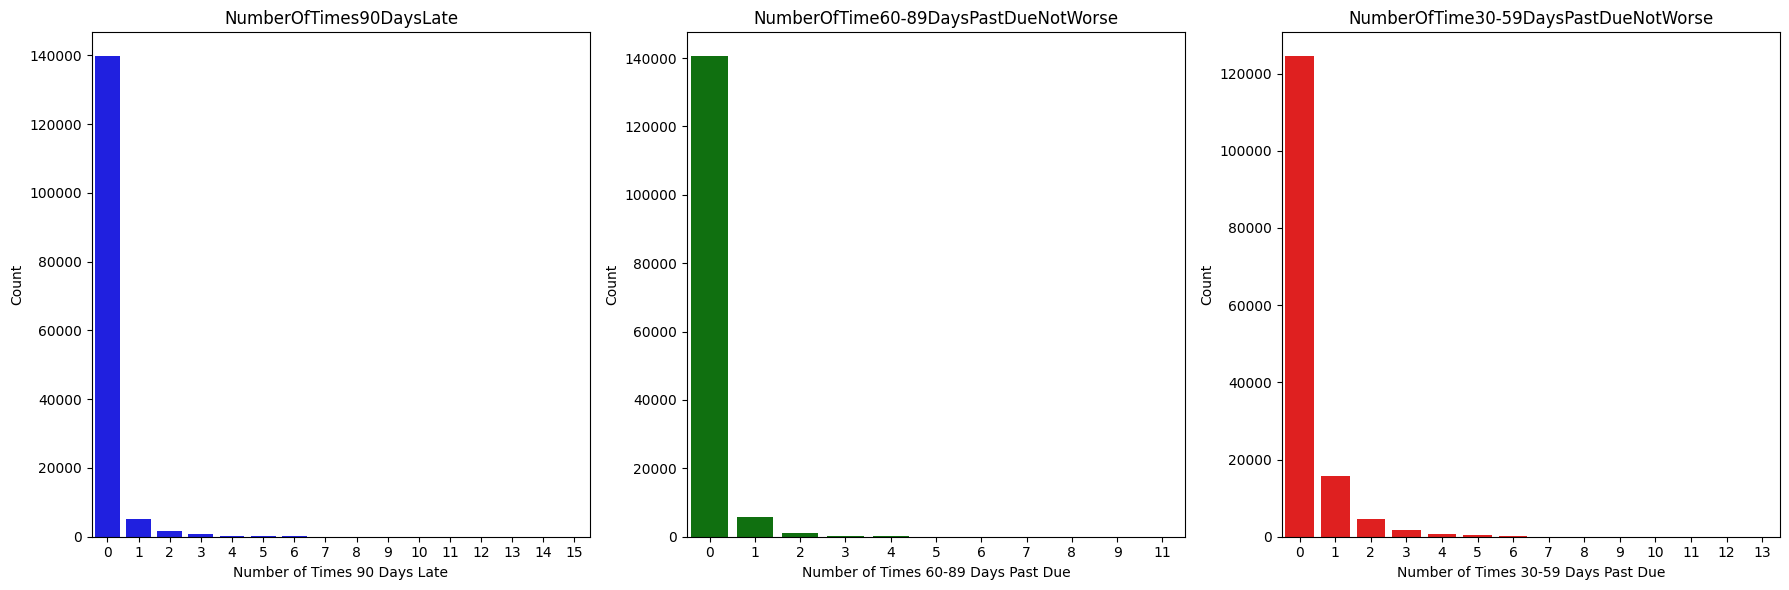

In [36]:
# Grid config
plt.figure(figsize=(18, 6))
gs = plt.GridSpec(1, 3)

# Plot count for NumberOfTimes90DaysLate
ax1 = plt.subplot(gs[0, 0])
sns.countplot(data=removed_outliers, x='NumberOfTimes90DaysLate', color='blue')
plt.title('NumberOfTimes90DaysLate')
plt.xlabel('Number of Times 90 Days Late')
plt.ylabel('Count')

# Plot count for NumberOfTime60-89DaysPastDueNotWorse
ax2 = plt.subplot(gs[0, 1])
sns.countplot(data=removed_outliers, x='NumberOfTime60-89DaysPastDueNotWorse', color='green')
plt.title('NumberOfTime60-89DaysPastDueNotWorse')
plt.xlabel('Number of Times 60-89 Days Past Due')
plt.ylabel('Count')

# Plot count for NumberOfTime30-59DaysPastDueNotWorse
ax3 = plt.subplot(gs[0, 2])
sns.countplot(data=removed_outliers, x='NumberOfTime30-59DaysPastDueNotWorse', color='red')
plt.title('NumberOfTime30-59DaysPastDueNotWorse')
plt.xlabel('Number of Times 30-59 Days Past Due')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

**After Outlier removal**

NumberOfTimes90DaysLate
No no one who is 90 or more days past due 15.

NumberOfTime60-89DaysPastDueNotWorse
No no one who is 90 or more days past due 11.

NumberOfTime30-59DaysPastDueNotWorse
No no one who is 90 or more days past due 13.

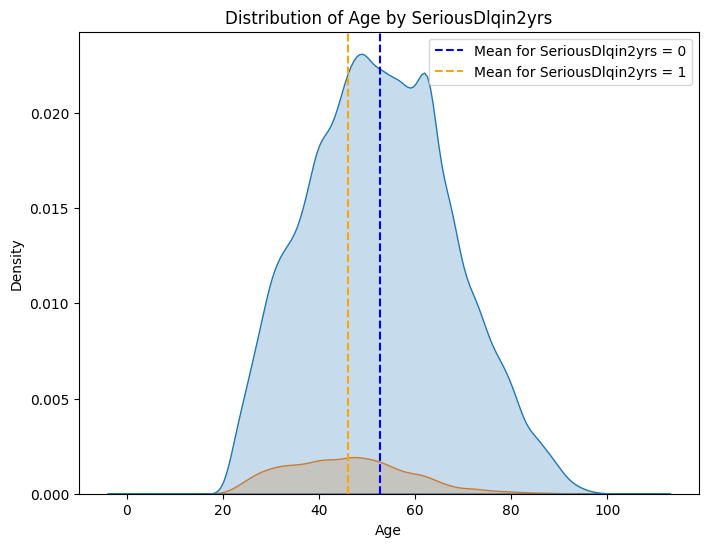

In [8]:
# Calculate the mean for each class of SeriousDlqin2yrs
mean_0 = removed_outliers_RUUL.loc[removed_outliers_RUUL['SeriousDlqin2yrs'] == 0, 'age'].mean()
mean_1 = removed_outliers_RUUL.loc[removed_outliers_RUUL['SeriousDlqin2yrs'] == 1, 'age'].mean()

plt.figure(figsize=(8, 6))
sns.kdeplot(data=removed_outliers_RUUL, x='age', hue='SeriousDlqin2yrs', fill=True)
plt.axvline(mean_0, linestyle='--', color='blue', label='Mean for SeriousDlqin2yrs = 0')
plt.axvline(mean_1, linestyle='--', color='orange', label='Mean for SeriousDlqin2yrs = 1')
plt.title('Distribution of Age by SeriousDlqin2yrs')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

Younger people have higher default.

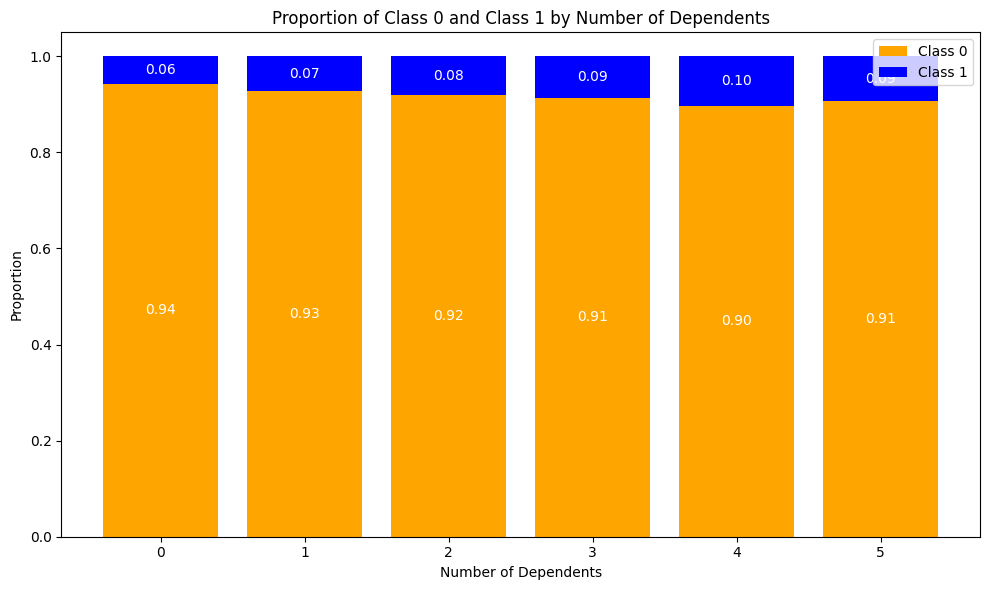

In [9]:
# Calculate proportion of default by 'NumberOfDependets'
prop_df = removed_outliers_RUUL.groupby(['NumberOfDependents', 'SeriousDlqin2yrs']).size().unstack()
prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)  # Dividir pelo total de cada linha para obter as proporções

# Plot bar plot
plt.figure(figsize=(10, 6))

# Set colors
colors = ['orange', 'blue']

# Plot bars for each class
for i in range(len(prop_df.columns)):
    plt.bar(prop_df.index, prop_df[prop_df.columns[i]], bottom=prop_df.iloc[:, :i].sum(axis=1), label=f'Class {prop_df.columns[i]}', color=colors[i])

# Add proportion value
for i in range(len(prop_df)):
    for j in range(len(prop_df.columns)):
        value = prop_df.iloc[i, j]
        plt.text(i, prop_df.iloc[:, :j].sum(axis=1)[i] + value / 2, f'{value:.2f}', ha='center', va='center', color='white', fontsize=10)

plt.xlabel('Number of Dependents')
plt.ylabel('Proportion')
plt.title('Proportion of Class 0 and Class 1 by Number of Dependents')
plt.legend()
plt.tight_layout()
plt.show()

People with 4 dependents have a higher proportion than the others.

People with one or no dependents have a lower rate of default.

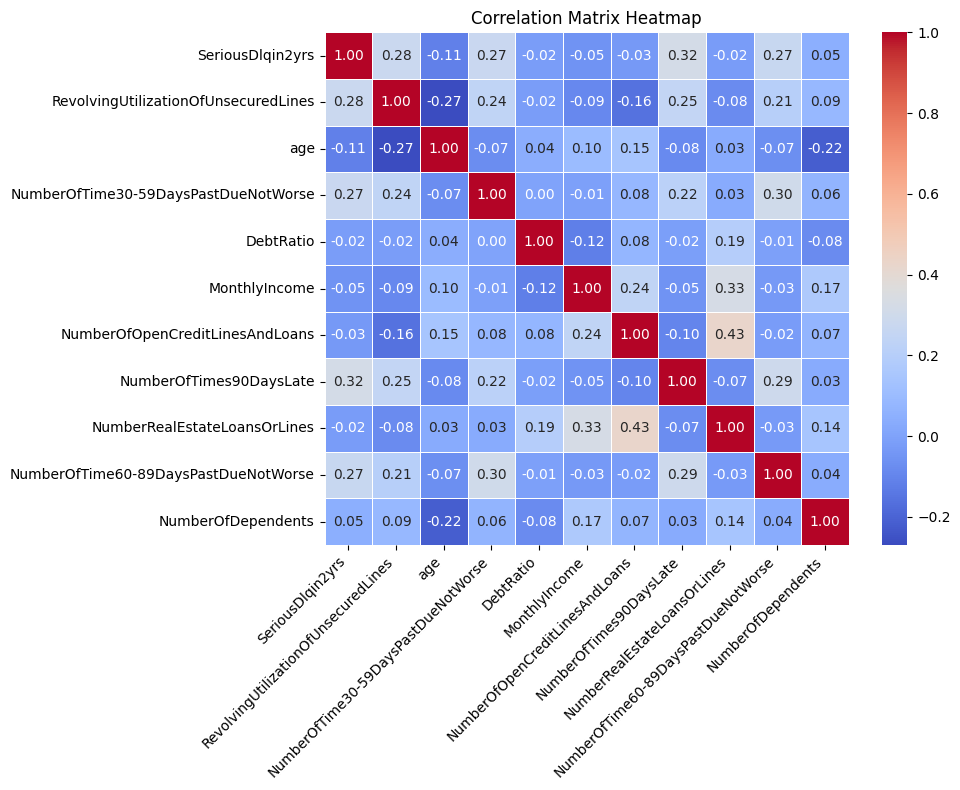

In [10]:
# Calculate the correlation matrix
corr_matrix = removed_outliers_RUUL.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

None of the variables showed a high correlation between them

## Imputation

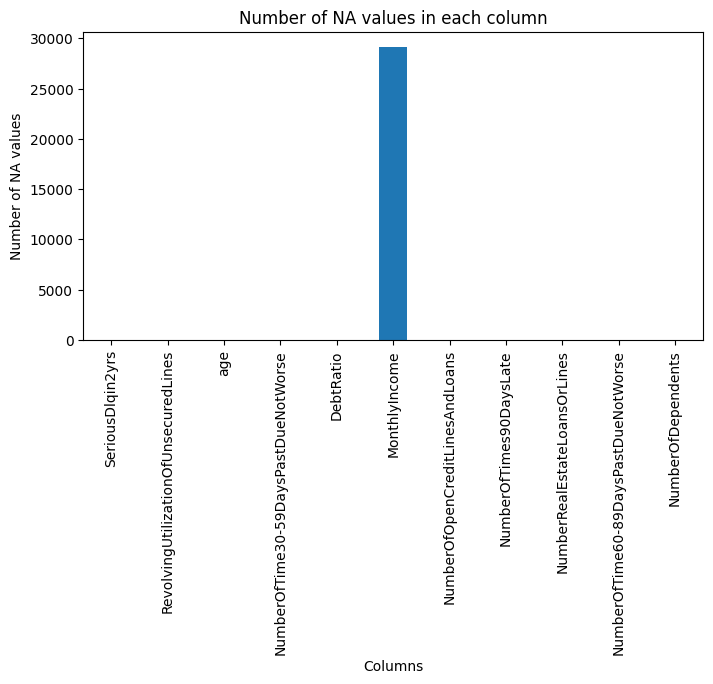

In [40]:
# Counting the number of NA values per column
na_counts = removed_outliers_RUUL.isna().sum()

# Plotting the bar chart
plt.figure(figsize=(8, 4))
na_counts.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Number of NA values')
plt.title('Number of NA values in each column')
plt.xticks(rotation=90)
plt.show()

In [32]:
# Imputation by Mean
imputed_df_mean = removed_outliers_RUUL.copy()

mean_imputer = SimpleImputer(strategy='mean')
imputed_df_mean['MonthlyIncome'] = mean_imputer.fit_transform(imputed_df_mean[['MonthlyIncome']])
imputed_df_mean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147664 entries, 2 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      147664 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  147664 non-null  float64
 2   age                                   147664 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  147664 non-null  int64  
 4   DebtRatio                             147664 non-null  float64
 5   MonthlyIncome                         147664 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       147664 non-null  int64  
 7   NumberOfTimes90DaysLate               147664 non-null  int64  
 8   NumberRealEstateLoansOrLines          147664 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  147664 non-null  int64  
 10  NumberOfDependents                    143803 non-null  float64
dtypes: fl

In [10]:
# MICE imputation
df_copy = removed_outliers_RUUL.copy()
missing_values = df_copy.isna()
imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_values = imputer.fit_transform(df_copy.values)
imputed_df_mice = pd.DataFrame(imputed_values, columns=df_copy.columns)

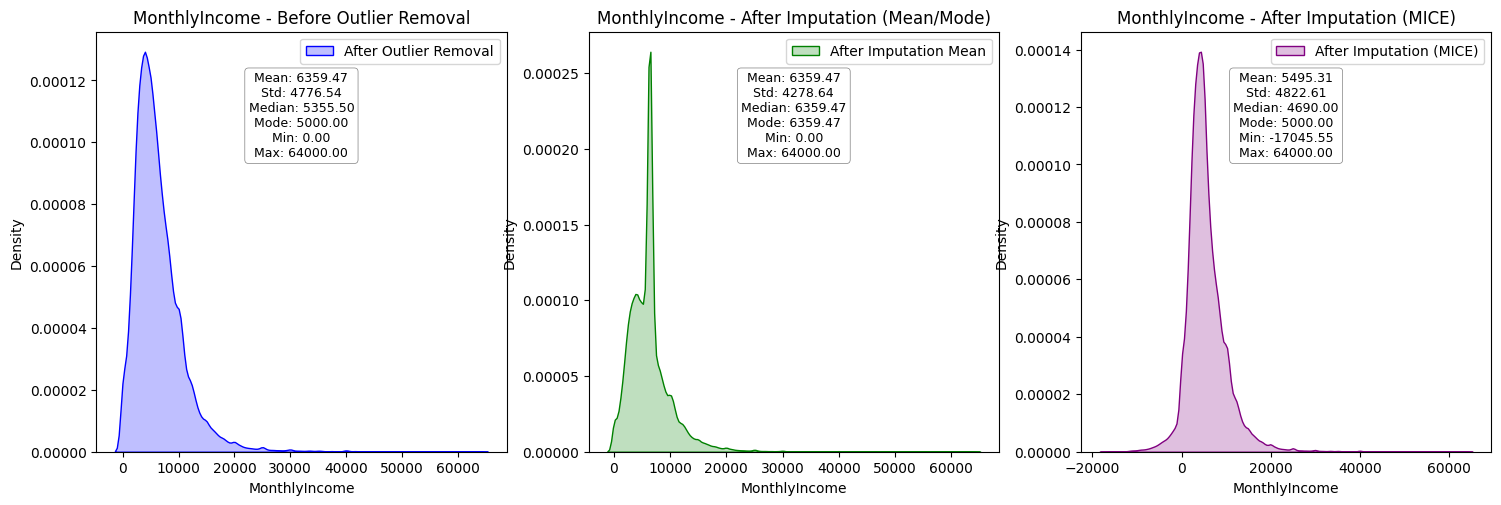

In [33]:
plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

# Plot without imputation - after outlier removal
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(data=removed_outliers_RUUL, x='MonthlyIncome', fill=True, color='blue', label='After Outlier Removal')
add_stats_to_plot(removed_outliers_RUUL, 'MonthlyIncome', ax1)
plt.title('MonthlyIncome - Before Outlier Removal')
plt.xlabel('MonthlyIncome')
plt.ylabel('Density')
plt.legend()

# Imputation by mean plot
ax2 = plt.subplot(gs[0, 1])
sns.kdeplot(data=imputed_df_mean, x='MonthlyIncome', fill=True, color='green', label='After Imputation Mean')
add_stats_to_plot(imputed_df_mean, 'MonthlyIncome', ax2)
plt.title('MonthlyIncome - After Imputation (Mean/Mode)')
plt.xlabel('MonthlyIncome')
plt.ylabel('Density')
plt.legend()

# MICE
ax3 = plt.subplot(gs[0, 2])
sns.kdeplot(data=imputed_df_mice, x='MonthlyIncome', fill=True, color='purple', label='After Imputation (MICE)')
add_stats_to_plot(imputed_df_mice, 'MonthlyIncome', ax3)
plt.title('MonthlyIncome - After Imputation (MICE)')
plt.xlabel('MonthlyIncome')
plt.ylabel('Density')
plt.legend()

The distribution of the MonthlyIncome variable was compared before and after imputation with the mean, or the MICE technique. When observing the plots, with MICE, the distribution was more similar to the distribution before imputation, so this technique was used to build the model.

In [11]:
# Verify duplicated rows
duplicated_rows = imputed_df_mice.duplicated()
duplicated_data = imputed_df_mice[duplicated_rows]
duplicated_data.count()

SeriousDlqin2yrs                        565
RevolvingUtilizationOfUnsecuredLines    565
age                                     565
NumberOfTime30-59DaysPastDueNotWorse    565
DebtRatio                               565
MonthlyIncome                           565
NumberOfOpenCreditLinesAndLoans         565
NumberOfTimes90DaysLate                 565
NumberRealEstateLoansOrLines            565
NumberOfTime60-89DaysPastDueNotWorse    565
NumberOfDependents                      565
dtype: int64

In [12]:
# Remove duplicates
df_final = imputed_df_mice.drop_duplicates()

Even having variables that take time into account, rows that contain exactly the same information, even in these variables, must be removed, after all, they do not bring more information about the data variability.

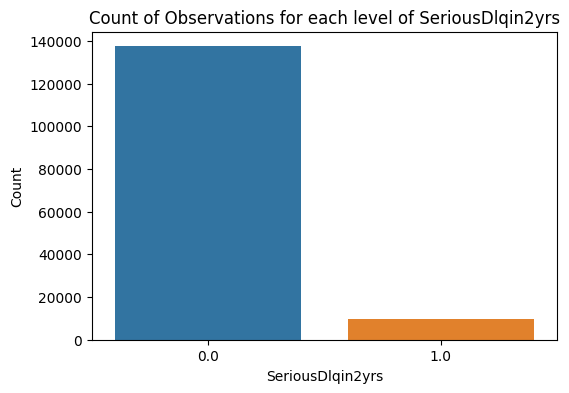

In [22]:
# Plot levels of target variable
plt.figure(figsize=(6, 4))
sns.countplot(data=df_final, x='SeriousDlqin2yrs')
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('Count')
plt.title('Count of Observations for each level of SeriousDlqin2yrs')

plt.show()

## Model Build

In [9]:
X = df_final.drop('SeriousDlqin2yrs', axis=1)
y = df_final['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# SMOTE - to deal with the imbalanced response variable
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Some algorithms for classification of "SeriousDlqin2yrs" were tested, with hyperparameters in Default, except for logistic regression, in order to avoid model convergence problems.

In [39]:
results = train_and_evaluate_models(X_train, X_test, y_train, y_test, X_train_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 6713, number of negative: 96256
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 102969, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065194 -> initscore=-2.662965
[LightGBM] [Info] Start training from score -2.662965
[LightGBM] [Info] Number of positive: 96256, number of negative: 96256
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 192512, number of used features: 10
[LightGBM] 

The metrics considered in the evaluation were weighted metrics, with unbalanced data, and macro metrics with balanced data. Evaluating the metrics of each model built with its hyperparameters in default, there is a greater difference in the training and test metrics, when used the SMOTE. Probably, when using this resampling technique, there was an overfitting of the models.

Considering greater explainability and lower computational cost when adjusting the hyperparameters, the chosen algorithm was logistic regression.

In [65]:
# Definy model
logreg_model = LogisticRegression(max_iter=1000, penalty='l2')

# What hiperparameters to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

# StratifiedKfold
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grisearch
grid_search_unbalanced = GridSearchCV(estimator=logreg_model, 
                                      param_grid=param_grid,
                                      scoring='recall_weighted', 
                                      cv=cv_stratified,
                                      n_jobs=-1)

grid_search_unbalanced.fit(X_train, y_train)
best_unbalanced_model = grid_search_unbalanced.best_estimator_
y_pred_train_unbalanced = best_unbalanced_model.predict(X_train)
y_pred_test_unbalanced = best_unbalanced_model.predict(X_test)

# Calculate metrics
recall_train_unbalanced = recall_score(y_train, y_pred_train_unbalanced, average='weighted')
precision_train_unbalanced = precision_score(y_train, y_pred_train_unbalanced, average='weighted')
auc_train_unbalanced = roc_auc_score(y_train, best_unbalanced_model.predict_proba(X_train)[:, 1], average='weighted')
f1_train_unbalanced = f1_score(y_train, y_pred_train_unbalanced, average='weighted')
recall_test_unbalanced = recall_score(y_test, y_pred_test_unbalanced, average='weighted')
precision_test_unbalanced = precision_score(y_test, y_pred_test_unbalanced, average='weighted')
auc_test_unbalanced = roc_auc_score(y_test, best_unbalanced_model.predict_proba(X_test)[:, 1], average='weighted')
f1_test_unbalanced = f1_score(y_test, y_pred_test_unbalanced, average='weighted')

# Store metrics
unbalanced_results = {
    "Model": "LogReg Unbalanced",
    "Data": "Train",
    "Model_Object": best_unbalanced_model,
    "Recall": recall_train_unbalanced,
    "Precision": precision_train_unbalanced,
    "AUC": auc_train_unbalanced,
    "F1-Score": f1_train_unbalanced
}

unbalanced_results_test = {
    "Model": "LogReg Unbalanced",
    "Data": "Test",
    "Recall": recall_test_unbalanced,
    "Precision": precision_test_unbalanced,
    "AUC": auc_test_unbalanced,
    "F1-Score": f1_test_unbalanced
}
# Set beta to F2-score (greater emphasis on recall)
beta = 2.0

# F2 to train data
f2_train_unbalanced = fbeta_score(y_train, y_pred_train_unbalanced, beta=beta, average='weighted')

# F2 to test data
f2_test_unbalanced = fbeta_score(y_test, y_pred_test_unbalanced, beta=beta, average='weighted')

unbalanced_results['F2-Score'] = f2_train_unbalanced
unbalanced_results_test['F2-Score'] = f2_test_unbalanced

# Print
print(unbalanced_results)
print(unbalanced_results_test)


{'Model': 'LogReg Unbalanced', 'Data': 'Train', 'Model_Object': LogisticRegression(C=0.01, max_iter=1000), 'Recall': 0.937592867756315, 'Precision': 0.9203225756882201, 'AUC': 0.8442537710650342, 'F1-Score': 0.9208126017807777, 'F2-Score': 0.9301481374600116}
{'Model': 'LogReg Unbalanced', 'Data': 'Test', 'Recall': 0.9374801722184455, 'Precision': 0.9209755143524503, 'AUC': 0.8467292275019358, 'F1-Score': 0.9210488938838807, 'F2-Score': 0.9301524673502601}


When dealing with financial decisions, such as lending money, false negatives are of greater concern. A false negative occurs when the model predicts that a borrower is not in default, but in reality, they are. This situation can be highly damaging because it means that the model failed to flag a risky borrower, and the company might end up granting a loan to someone who is likely to default. This could result in financial losses for the lender and affect the overall stability of the lending portfolio.

To mitigate this risk, we focus on maximizing recall during hyperparameter tuning. By doing so, we prioritize reducing the number of false negatives, ensuring that the model is more adept at capturing borrowers who are genuinely at a higher risk of defaulting. In essence, we want the model to be highly sensitive to detecting default cases, even if it means accepting a slightly higher number of false positives (classifying someone as a defaulter when they are not). The trade-off here is intentional, as it prioritizes the avoidance of missing potentially risky borrowers over being overly conservative in lending decisions.

The training and test data metrics don't have great difference, which may indicate that there was no model overfitting.

With a recall value of 0.93, it means that the model is hitting 93.74% of the positive instances correctly. This includes both true positives (TP) and false negatives (FN).

An F2-Score of 0.93 suggests that it is effective in reducing false negatives. This indicates that the model has a good ability to correctly identify positive examples and is therefore valuable in scenarios where minimizing false negatives is a priority.

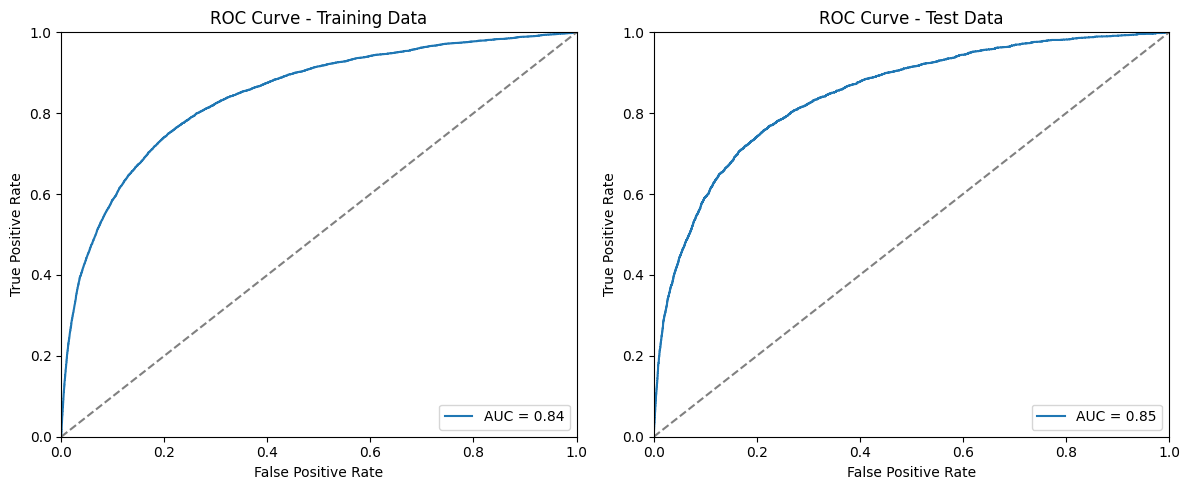

In [63]:
# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC curve for training data
plot_roc_curve_custom(best_unbalanced_model, X_train, y_train, title='ROC Curve - Training Data', ax=axes[0])

# Plot ROC curve for test data
plot_roc_curve_custom(best_unbalanced_model, X_test, y_test, title='ROC Curve - Test Data', ax=axes[1])

plt.tight_layout()
plt.show()


An AUC curve of 0.85 means that the model has an 85% probability of correctly classifying a positive sample as more likely to belong to the positive class than a negative sample. In other words, the model has a high true positive rate (TPR) and a low false positive rate (FPR).

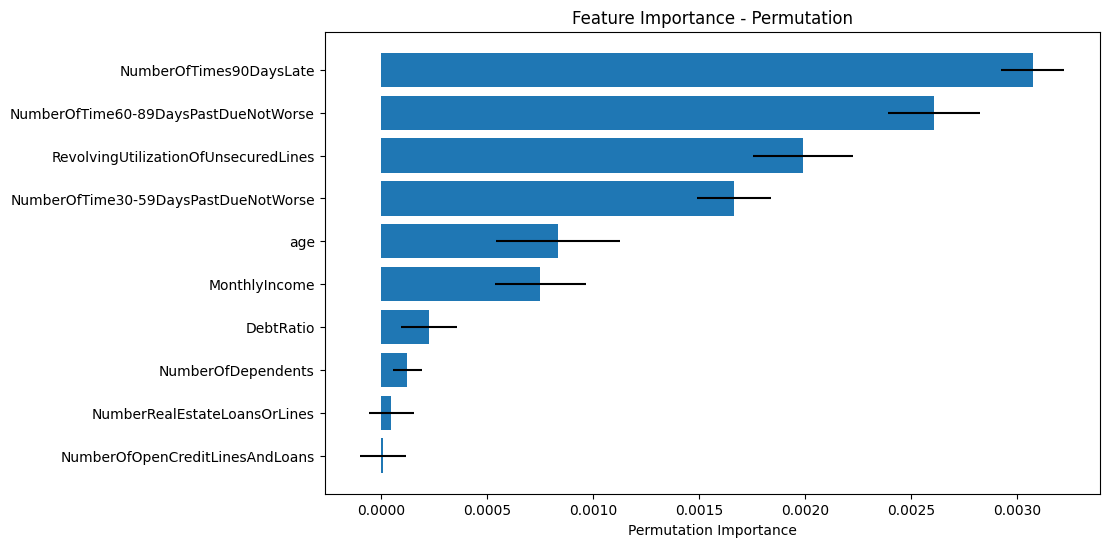

In [44]:
# Calculate permutation importance for each feature
perm_importance = permutation_importance(best_unbalanced_model, X_test, y_test, n_repeats=30, random_state=42)

# Get the feature names
feature_names = X_train.columns

# Sort the features based on their importance
sorted_idx = perm_importance.importances_mean.argsort()

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], xerr=perm_importance.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance - Permutation')
plt.show()

Other tests should be performed, also removing or transforming variables of lesser importance to the model such as NumberOfOpenCreditLinesAndLoans.

In [ ]:
# Save the model to a .pkl file
filename = 'logreg_model.pkl'
joblib.dump(best_unbalanced_model, filename)

## How to improve model performance

* To improve the performance of the built model, other variables that are important for granting credit can be considered, such as average salary, length of employment registered in the portfolio, some scores that are already commonly used, as the serasa score.

* Deep Learning algorithms can also be considered, as well as ensemble methods, which combine the predictions of several models, however, when using more complex models, there is a loss of explainability and greater computational demand.

* Previous transformations and combinations of these transformations with the proposed algorithms can result in better metrics.

* Grouping continuous variables with high standard deviation, transforming them into categorical variables, reducing variability.

* Remove less important variables and check model metrics again.

* Other resampling techniques such as Adaptive Synthetic Sampling or Cluster Centroids.

* Search for Auto ML solutions to reduce the time in testing transformations and combinations of algorithms, giving a guide for which algorithms and variables to select.

* Use the principal components of a PCA, if these components explain the variability of the data well, as predictor variables of the model.